# Ibovespa forecasting using neural networks

## Machine Learning Engineer Nanodegree - Capstone Proposal

### Import python packages

In [10]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from ibovespa.utils import load_config
from ibovespa.data_collection import collect_data
from ibovespa.data_preparation import prepare_data

### Load Configurations

In [4]:
config = load_config()

### Data Collection

In [6]:
period = config["data_collection"]["period"]
stocks = config["data_collection"]["stocks"]

raw_data = collect_data(stocks=stocks, data_size=period)

In [7]:
raw_data.tail()

,date,^BVSP,ITUB4,BBDC4,VALE3,PETR4,PETR3,ABEV3,BBAS3,B3SA3,ITSA4
359,2021-01-22,117172.0,29.150000,24.990000,92.629997,27.020000,27.700001,15.03,33.419998,58.459999,10.82
360,2021-01-26,116464.0,28.250000,24.410000,91.750000,27.000000,27.600000,15.40,32.790001,59.299999,10.62
361,2021-01-27,115882.0,28.250000,24.760000,89.199997,27.400000,27.980000,15.40,33.750000,59.009998,10.55
362,2021-01-28,119314.0,29.389999,25.530001,91.099998,27.760000,28.600000,15.54,34.540001,61.290001,10.97
363,2021-01-29,116007.0,28.340000,24.740000,87.949997,26.690001,27.330000,15.11,33.860001,59.799999,10.61


### Data Preparation

In [11]:
test_split  = config["data_preparation"]["split_size"]["test"]
valid_split = config["data_preparation"]["split_size"]["validation"]

clean_data = prepare_data(raw_data, split=test_split, split_valid=valid_split)

### Data Exploration

It is important to evaluate data and get insights only form the train dataset. Otherwise, we will have a data leakage even before any model training.

In [12]:
explore_data = clean_data[clean_data["group"]=="train"]

# Calendar Variables
calendar_variables = pd.get_dummies(pd.DatetimeIndex(explore_data['date']).weekday, prefix="weekday")
explore_data = pd.concat([explore_data, calendar_variables], axis = 1)
explore_data[["weekday"]] = pd.DatetimeIndex(explore_data['date']).weekday

numeric_columns = ['IBOV', 'ITUB4', 'BBDC4', 'VALE3', 'PETR4', 'PETR3', 'ABEV3', 'BBAS3', 'B3SA3', 'ITSA4']
stocks_diff = explore_data[numeric_columns].pct_change().reset_index(drop=True)
stocks_diff.columns = ["diff_" + column for column in stocks_diff.columns]

complete_explore_data = pd.concat([explore_data, stocks_diff], axis=1).iloc[1:].reset_index(drop=True)
complete_explore_data.head()

,date,IBOV,ITUB4,BBDC4,VALE3,PETR4,PETR3,ABEV3,BBAS3,B3SA3,...,diff_IBOV,diff_ITUB4,diff_BBDC4,diff_VALE3,diff_PETR4,diff_PETR3,diff_ABEV3,diff_BBAS3,diff_B3SA3,diff_ITSA4
0,2019-08-09,103996.0,36.720001,31.345453,45.490002,26.280001,28.620001,20.070000,48.650002,45.500000,...,-0.001143,-0.007568,-0.016543,-0.035820,-0.002657,-0.008660,-0.004958,-0.003074,0.003750,-0.004573
1,2019-08-12,101915.0,35.200001,30.690908,45.160000,25.650000,27.850000,19.480000,47.000000,44.240002,...,-0.020010,-0.041394,-0.020882,-0.007254,-0.023973,-0.026904,-0.029397,-0.033916,-0.027692,-0.035222
2,2019-08-13,103299.0,35.889999,31.000000,46.500000,25.790001,27.959999,19.379999,47.549999,45.860001,...,0.013580,0.019602,0.010071,0.029672,0.005458,0.003950,-0.005133,0.011702,0.036618,0.025397
3,2019-08-14,100258.0,35.099998,30.390909,44.880001,24.920000,27.100000,19.010000,45.889999,43.700001,...,-0.029439,-0.022012,-0.019648,-0.034839,-0.033734,-0.030758,-0.019092,-0.034911,-0.047100,-0.013158
4,2019-08-15,99057.0,35.000000,30.181818,43.889999,24.230000,26.500000,18.780001,45.849998,43.349998,...,-0.011979,-0.002849,-0.006880,-0.022059,-0.027689,-0.022140,-0.012099,-0.000872,-0.008009,0.003922


#### Weekday Boxplots

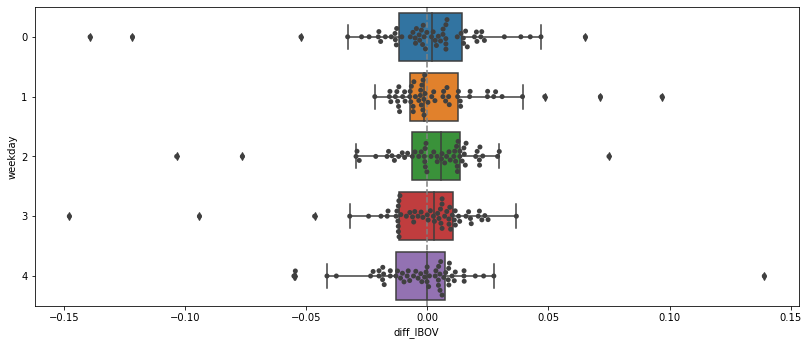

In [15]:
f, ax = plt.subplots(figsize=(13.7, 5.5))
sns.boxplot(y="weekday", x="diff_IBOV", data=complete_explore_data, orient="h", ax=ax)
sns.swarmplot(x="diff_IBOV", y="weekday", orient="h", data=complete_explore_data, color=".25", ax=ax)
plt.axvline(0, 0,1, ls="--", color="gray")

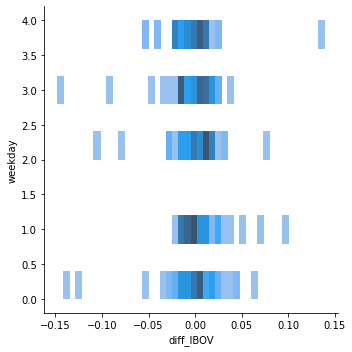

In [17]:
sns.displot(y="weekday", x="diff_IBOV", data=complete_explore_data)

#### Correlations

In [19]:
last_day_diff = complete_explore_data.iloc[:-1][['diff_ITUB4', 'diff_BBDC4', 'diff_VALE3', 'diff_PETR4', 'diff_PETR3',
       'diff_ABEV3', 'diff_BBAS3', 'diff_B3SA3', 'diff_ITSA4']].reset_index(drop=True)

today_diff_close = complete_explore_data.iloc[1:][["diff_IBOV"]].reset_index(drop=True)

diff_evaluation = pd.concat([today_diff_close, last_day_diff], axis=1)

In [20]:
diff_evaluation.corr(method="spearman")

,diff_IBOV,diff_ITUB4,diff_BBDC4,diff_VALE3,diff_PETR4,diff_PETR3,diff_ABEV3,diff_BBAS3,diff_B3SA3,diff_ITSA4
diff_IBOV,1.000000,-0.138315,-0.142408,-0.070556,-0.126326,-0.113145,-0.217774,-0.142318,-0.136587,-0.129423
diff_ITUB4,-0.138315,1.000000,0.902884,0.440626,0.587315,0.619670,0.506046,0.833148,0.569812,0.938732
diff_BBDC4,-0.142408,0.902884,1.000000,0.455133,0.632711,0.660816,0.529250,0.868094,0.596928,0.880955
diff_VALE3,-0.070556,0.440626,0.455133,1.000000,0.536991,0.563135,0.311824,0.447753,0.378166,0.442505
diff_PETR4,-0.126326,0.587315,0.632711,0.536991,1.000000,0.958641,0.440405,0.594676,0.505579,0.605969
diff_PETR3,-0.113145,0.619670,0.660816,0.563135,0.958641,1.000000,0.461524,0.620270,0.519856,0.635241
diff_ABEV3,-0.217774,0.506046,0.529250,0.311824,0.440405,0.461524,1.000000,0.473989,0.487367,0.508573
diff_BBAS3,-0.142318,0.833148,0.868094,0.447753,0.594676,0.620270,0.473989,1.000000,0.611705,0.825760
diff_B3SA3,-0.136587,0.569812,0.596928,0.378166,0.505579,0.519856,0.487367,0.611705,1.000000,0.606984
diff_ITSA4,-0.129423,0.938732,0.880955,0.442505,0.605969,0.635241,0.508573,0.825760,0.606984,1.000000


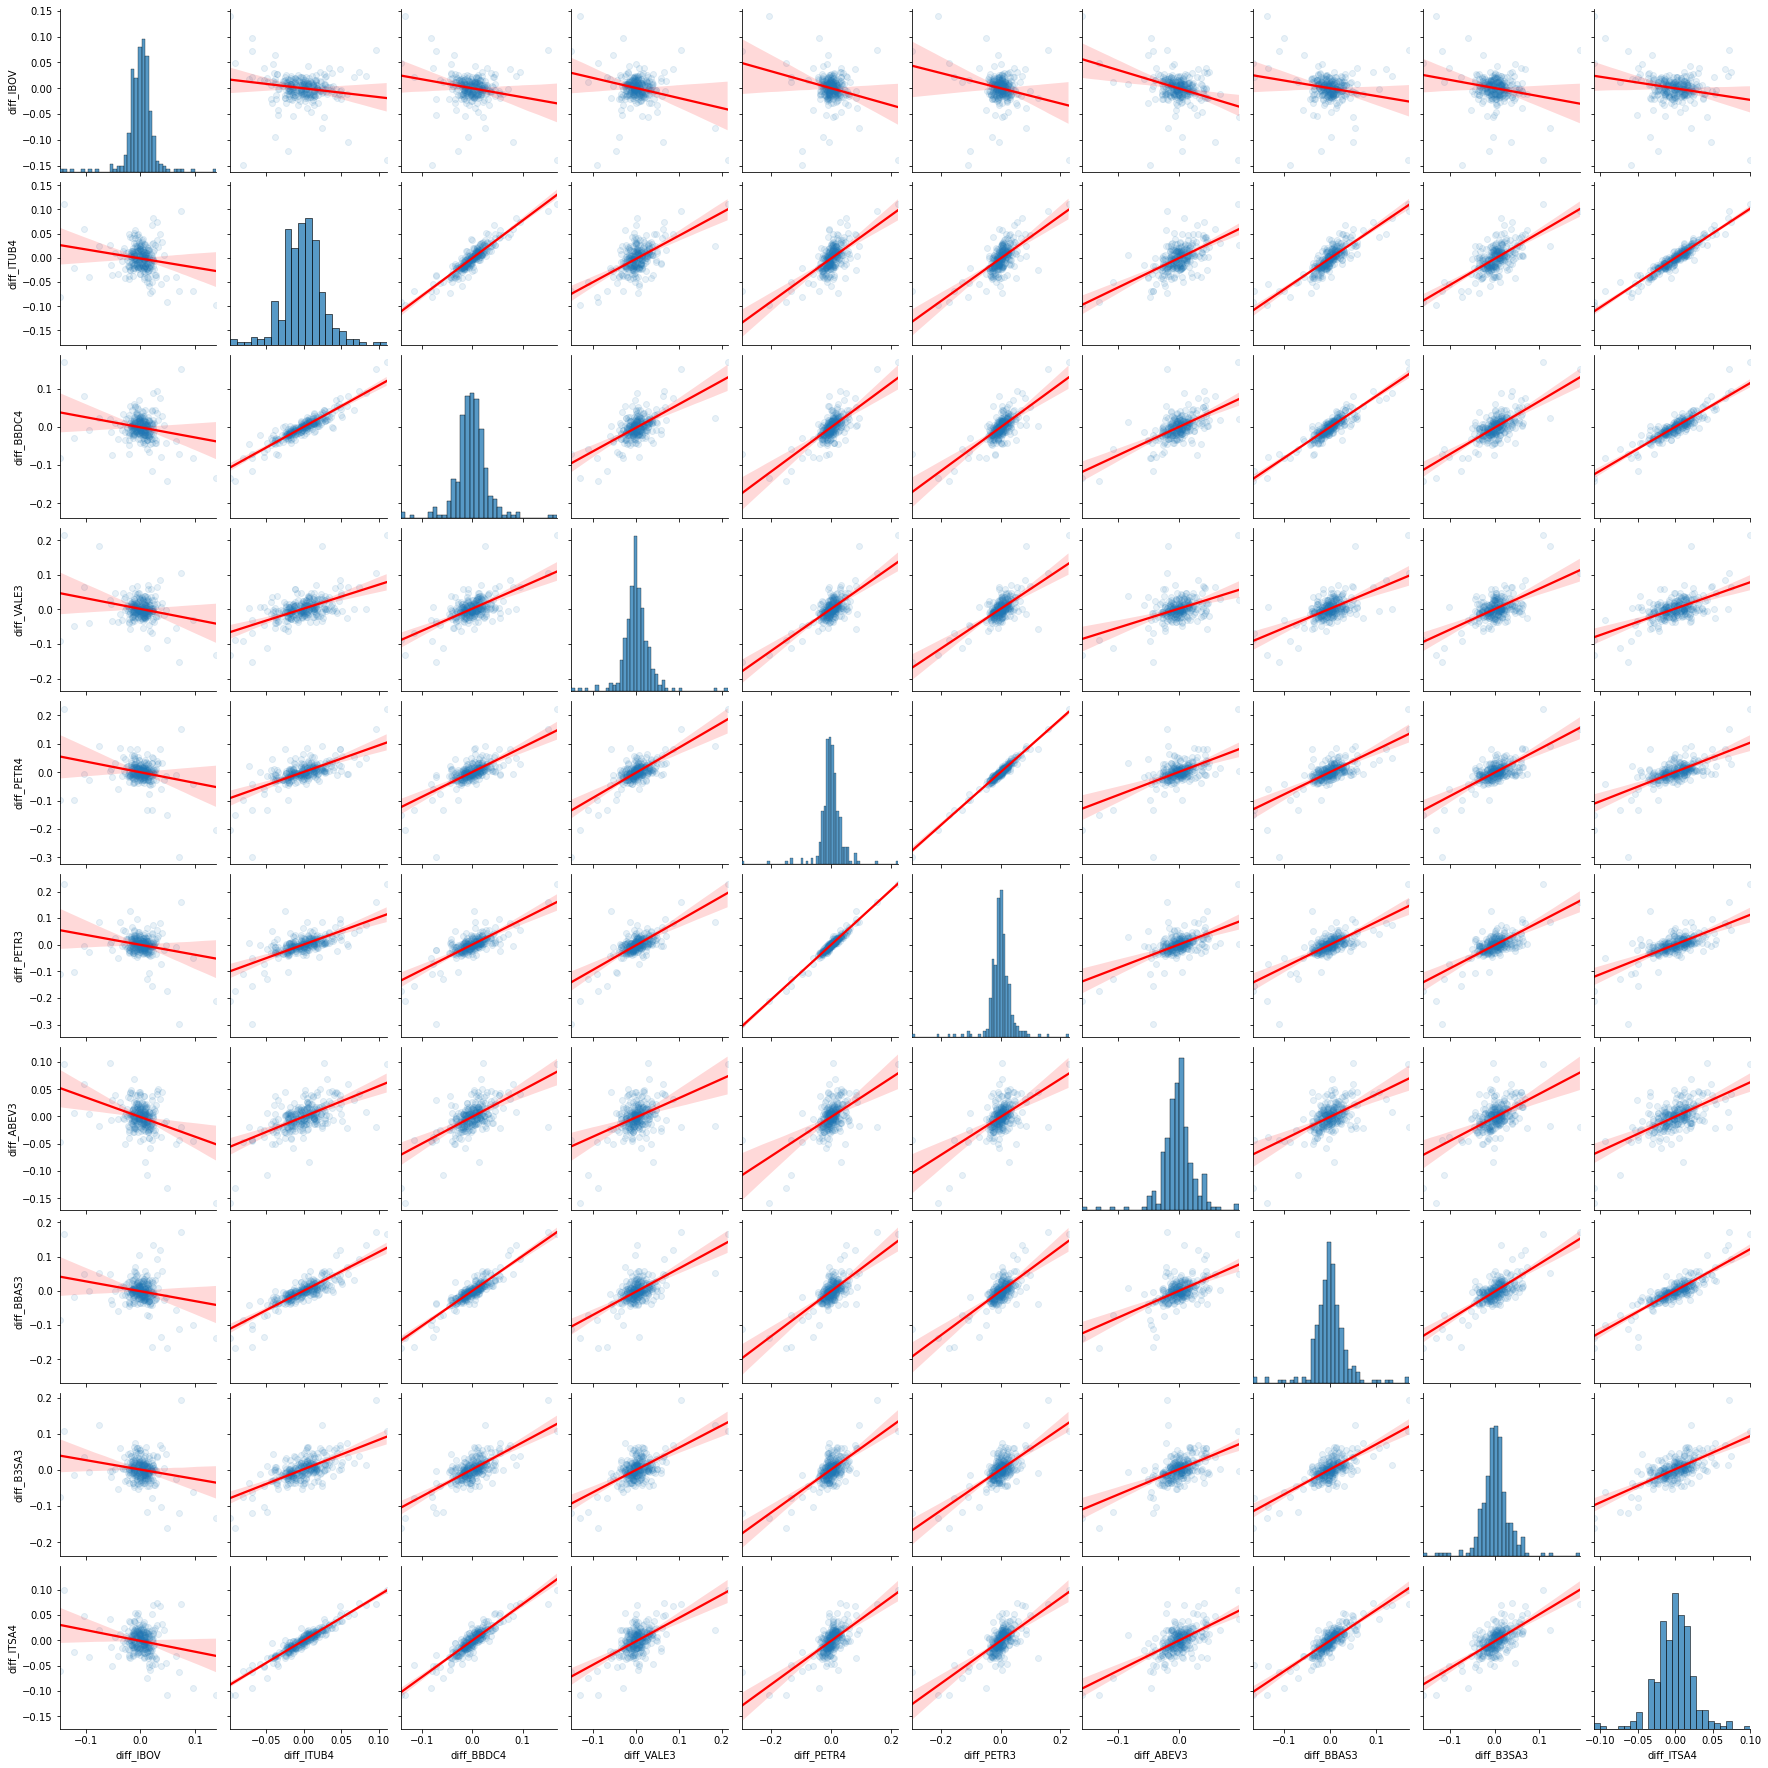

In [21]:
sns.pairplot(diff_evaluation, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

#### Conclusions from data

The boxplots of Ibovespa value difference overnight for each weekday show that wednesday and thursday are days when a positive variation is observed at median. Therefore, these are potential variables for the model.

Stock prices variation have almost no linear correlation with Ibovespa variation, but have high correlation between themselves. 